In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools

In [2]:
def read_img(path):
    # opencv read image in BGR color space
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_rgb, img_gray

def SIFT(gray_img):
    '''
        Use SIFT to get the keypoint and descriptor of the keypoint

        Args:
            gray_img: SIFT need gray scale image as input
        
        Returns:
            keypoint: The keypoints tuple 
            des: The 128-dim of each keypoint

    '''
    sift_detector = cv2.SIFT_create()
    keypoint, des = sift_detector.detectAndCompute(gray_img, None)
    return keypoint, des

def match_keypoint(kp_left, kp_right, des_left, des_right):
    match = []
    K = 2
    ratio = 0.7

    for i in range(des_left.shape[0]):
        distance = np.linalg.norm(des_left[i] - des_right, axis=1)
        nearest_neighbor_ids = distance.argsort()[:K]
        if (distance[nearest_neighbor_ids[0]] < ratio * distance[nearest_neighbor_ids[1]]):
            match.append([kp_left[i].pt, kp_right[nearest_neighbor_ids[0]].pt])
    
    # The result will have duplicate keypoint but with different descriptor, 
    # but we only interest at keypoiny coordinate to image stitching, so remove duplicate ones.
    remove_dupliacte = []
    remove_dupliacte = sorted(match)
    remove_dupliacte = list(remove_dupliacte for remove_dupliacte, _ in itertools.groupby(remove_dupliacte))
    
    return remove_dupliacte

def homography(pairs):
    """
        solve p1' = H * p1, (H is homograpy matrix we want to get)

        Args: 
            pairs = [[(x1, y1), (x1', y1')], [(x2,y2), (x2', y2')], ...]
            pairs should have at least 4 pairs.
            
    """
    A = []
    for i in range(len(pairs)):
        p1 = pairs[i][0] #(x1, y1)
        p2 = pairs[i][1] #(x1', y1')

        # [x1, y1, 1, 0, 0, 0, -x1'x1, -x1'y1, -x1']
        A.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]])
        # [0, 0, 0, x1, y1, 1, -y1'x1, -y1'y1, -y1']
        A.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]])

    # use SVD to solve the linear equation A*H = 0
    # find the smallest number in s and H = corresponding vector in vt
    # np.linalg.svd() will return s in descending order, so we can get the last vector in vt to get H
    u, s, vt = np.linalg.svd(A)
    H = vt[-1].reshape(3, 3)

    # normalize h22 to 1
    H = H/H[2, 2]
    return H

def RANSAC(match_point, iteration, threshold):
    max_inlier = 0
    best_H = None
    
    for i in range(iteration):
        # get 4 random points at match_point and calculate homography matrix
        random_match = random.sample(match_point, 4)
        H = homography(random_match)
        
        # find the best homography matrix that has the max number of inliners
        inlinr_num = 0
        for j in range(len(match_point)):
            if match_point[j] not in random_match:
                src_point, dst_point = match_point[j]
                src_point = np.hstack((src_point, [1])) # add z-axis

                correspond_point = np.matmul(H, src_point)
                correspond_point = correspond_point / correspond_point[2]
                if (np.linalg.norm(correspond_point[:2] - dst_point) < threshold):
                    inlinr_num += 1
                
        if max_inlier < inlinr_num:
            max_inlier = inlinr_num
            best_H = H
        
        # when inlier/match_count > 80%, end loop
        if max_inlier/len(match_point) > 0.8:
            break

    
    print(f"best inlier/match_count: {max_inlier}/{len(match_point)}")
    return best_H



In [3]:
def warp_img(img1, img2, H):
    # left image
    height_l, width_l, channel_l = img1.shape
    corners = [[0, 0, 1], [width_l, 0, 1], [width_l, height_l, 1], [0, height_l, 1]]
    corners_new = [np.dot(H, corner) for corner in corners]
    corners_new = np.array(corners_new).T 
    x_news = corners_new[0] / corners_new[2]
    y_news = corners_new[1] / corners_new[2]
    y_min = min(y_news)
    x_min = min(x_news)

    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H = np.dot(translation_mat, H)
    
    # Get height, width
    height_new = int(round(abs(y_min) + height_l))
    width_new = int(round(abs(x_min) + width_l))
    size = (width_new, height_new)

    # right image
    warped_l = cv2.warpPerspective(src=img1, M=H, dsize=size)

    height_r, width_r, channel_r = img2.shape
    
    height_new = int(round(abs(y_min) + height_r))
    width_new = int(round(abs(x_min) + width_r))
    size = (width_new, height_new)

    warped_r = cv2.warpPerspective(src=img2, M=translation_mat, dsize=size)

    return warped_l, warped_r

def blend_img(warped_l, warped_r):
    alpha = 0.5
    beta = (1.0 - alpha)
    dst = cv2.addWeighted(warped_l, alpha, warped_r, beta, 0.0)

    _, mask_left = cv2.threshold(warped_l, 0, 1, cv2.THRESH_BINARY)
    _, mask_right = cv2.threshold(warped_r, 0, 1, cv2.THRESH_BINARY)
    overlap = (mask_left + mask_right - 1)

    result = warped_l + warped_r - overlap*dst

    return result

In [ ]:
def drawMatches(imgs, matches_pos):
        '''
            Draw the match points img with keypoints and connection line
        '''
        
        # initialize the output visualization image
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        vis = np.zeros((max(hl, hr), wl + wr, 3), dtype="uint8")
        vis[0:hl, 0:wl] = img_left
        vis[0:hr, wl:] = img_right
        
        # Draw the match
        for (img_left_pos, img_right_pos) in matches_pos:
                pos_l = int(img_left_pos[0]), int(img_left_pos[1])
                pos_r = int(img_right_pos[0]) + wl, int(img_right_pos[1])
                cv2.circle(vis, pos_l, 3, (0, 0, 255), 1)
                cv2.circle(vis, pos_r, 3, (0, 255, 0), 1)
                cv2.line(vis, pos_l, pos_r, (255, 0, 0), 1)
                
        # return the visualization
        plt.figure(figsize=(100, 100))
        plt.title("img with matching points")
        plt.imshow(vis[:,:,::-1])
        #cv2.imwrite("Feature matching img/matching.jpg", vis)
        
        return vis

drawMatches((left_img, right_img), match_point)


In [9]:
left_img, left_img_gray = read_img("./test/m2.jpg")
right_img, right_img_gray = read_img("./test/m4.jpg")

left_kp, left_des = SIFT(left_img_gray)
right_kp, right_des = SIFT(right_img_gray)

match_point = match_keypoint(left_kp, right_kp, left_des, right_des)
#match_point = match_keypoint(right_kp, left_kp, right_des, left_des)

In [10]:
H = RANSAC(match_point, iteration=3000, threshold=3)

best inlier/match_count: 232/342


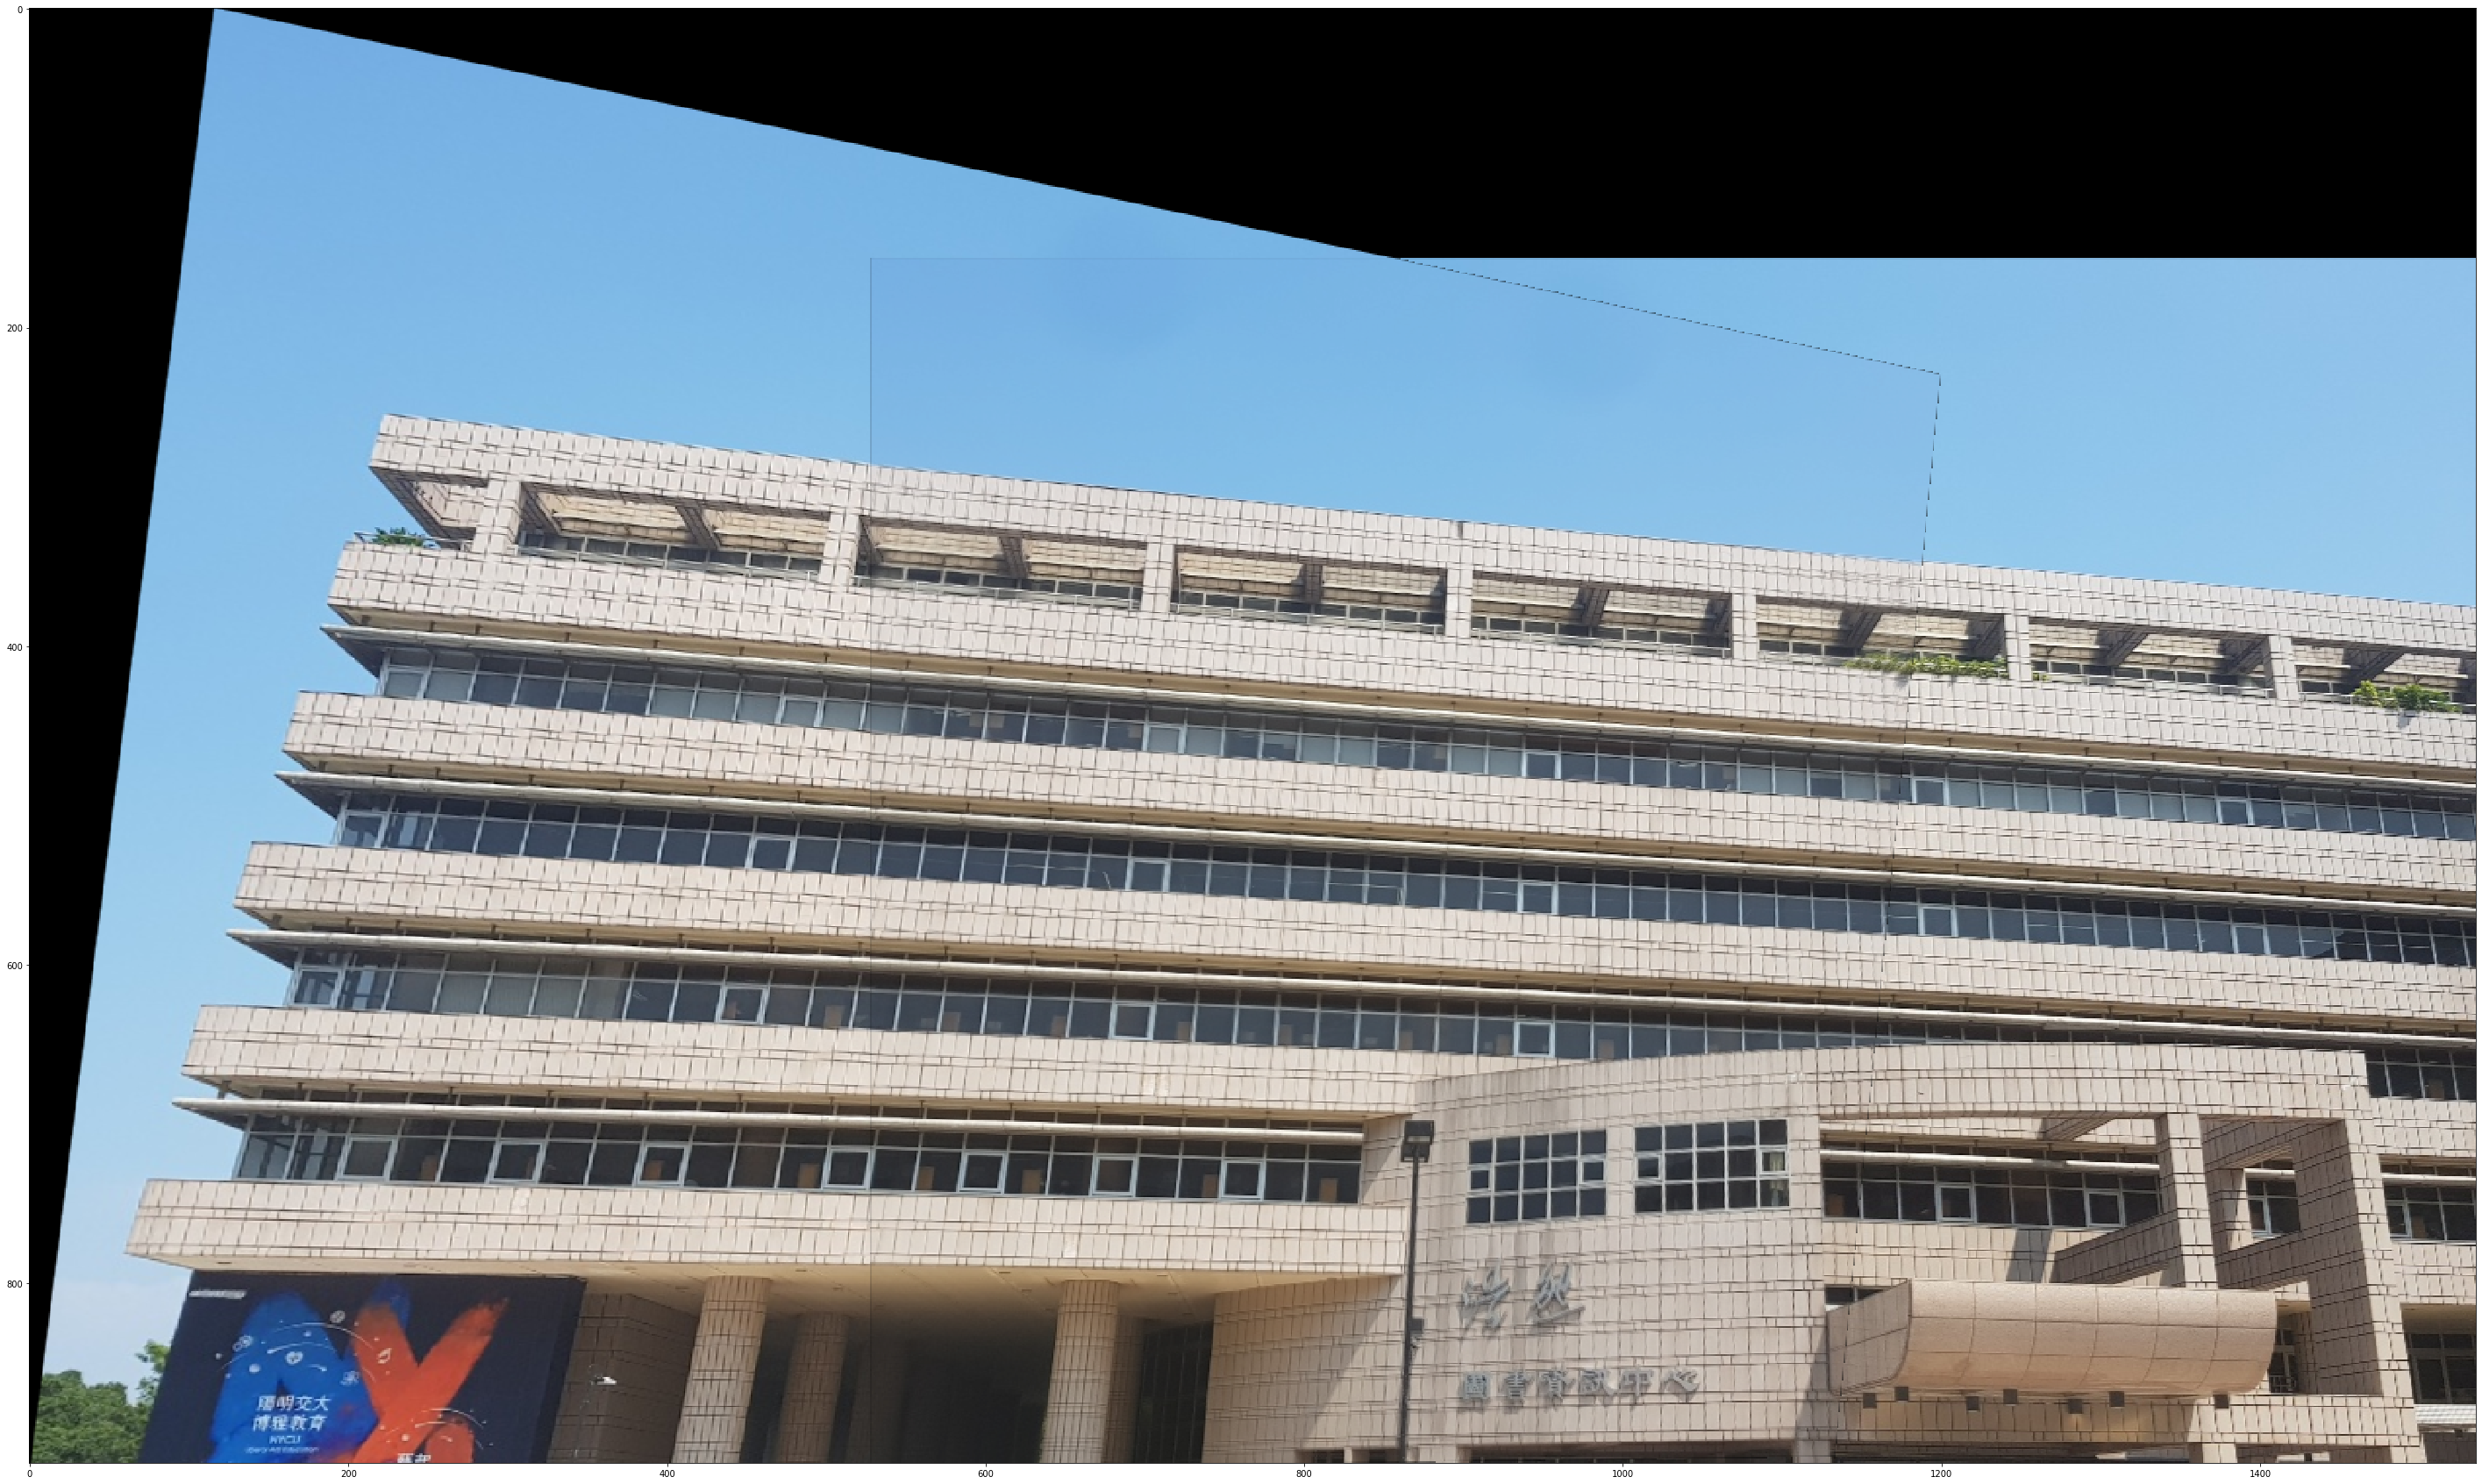

In [11]:
warp_l, warp_r = warp_img(left_img, right_img, H)
warp = blend_img(warp_l, warp_r)
plt.figure(figsize=(50,50))
plt.imshow(warp)

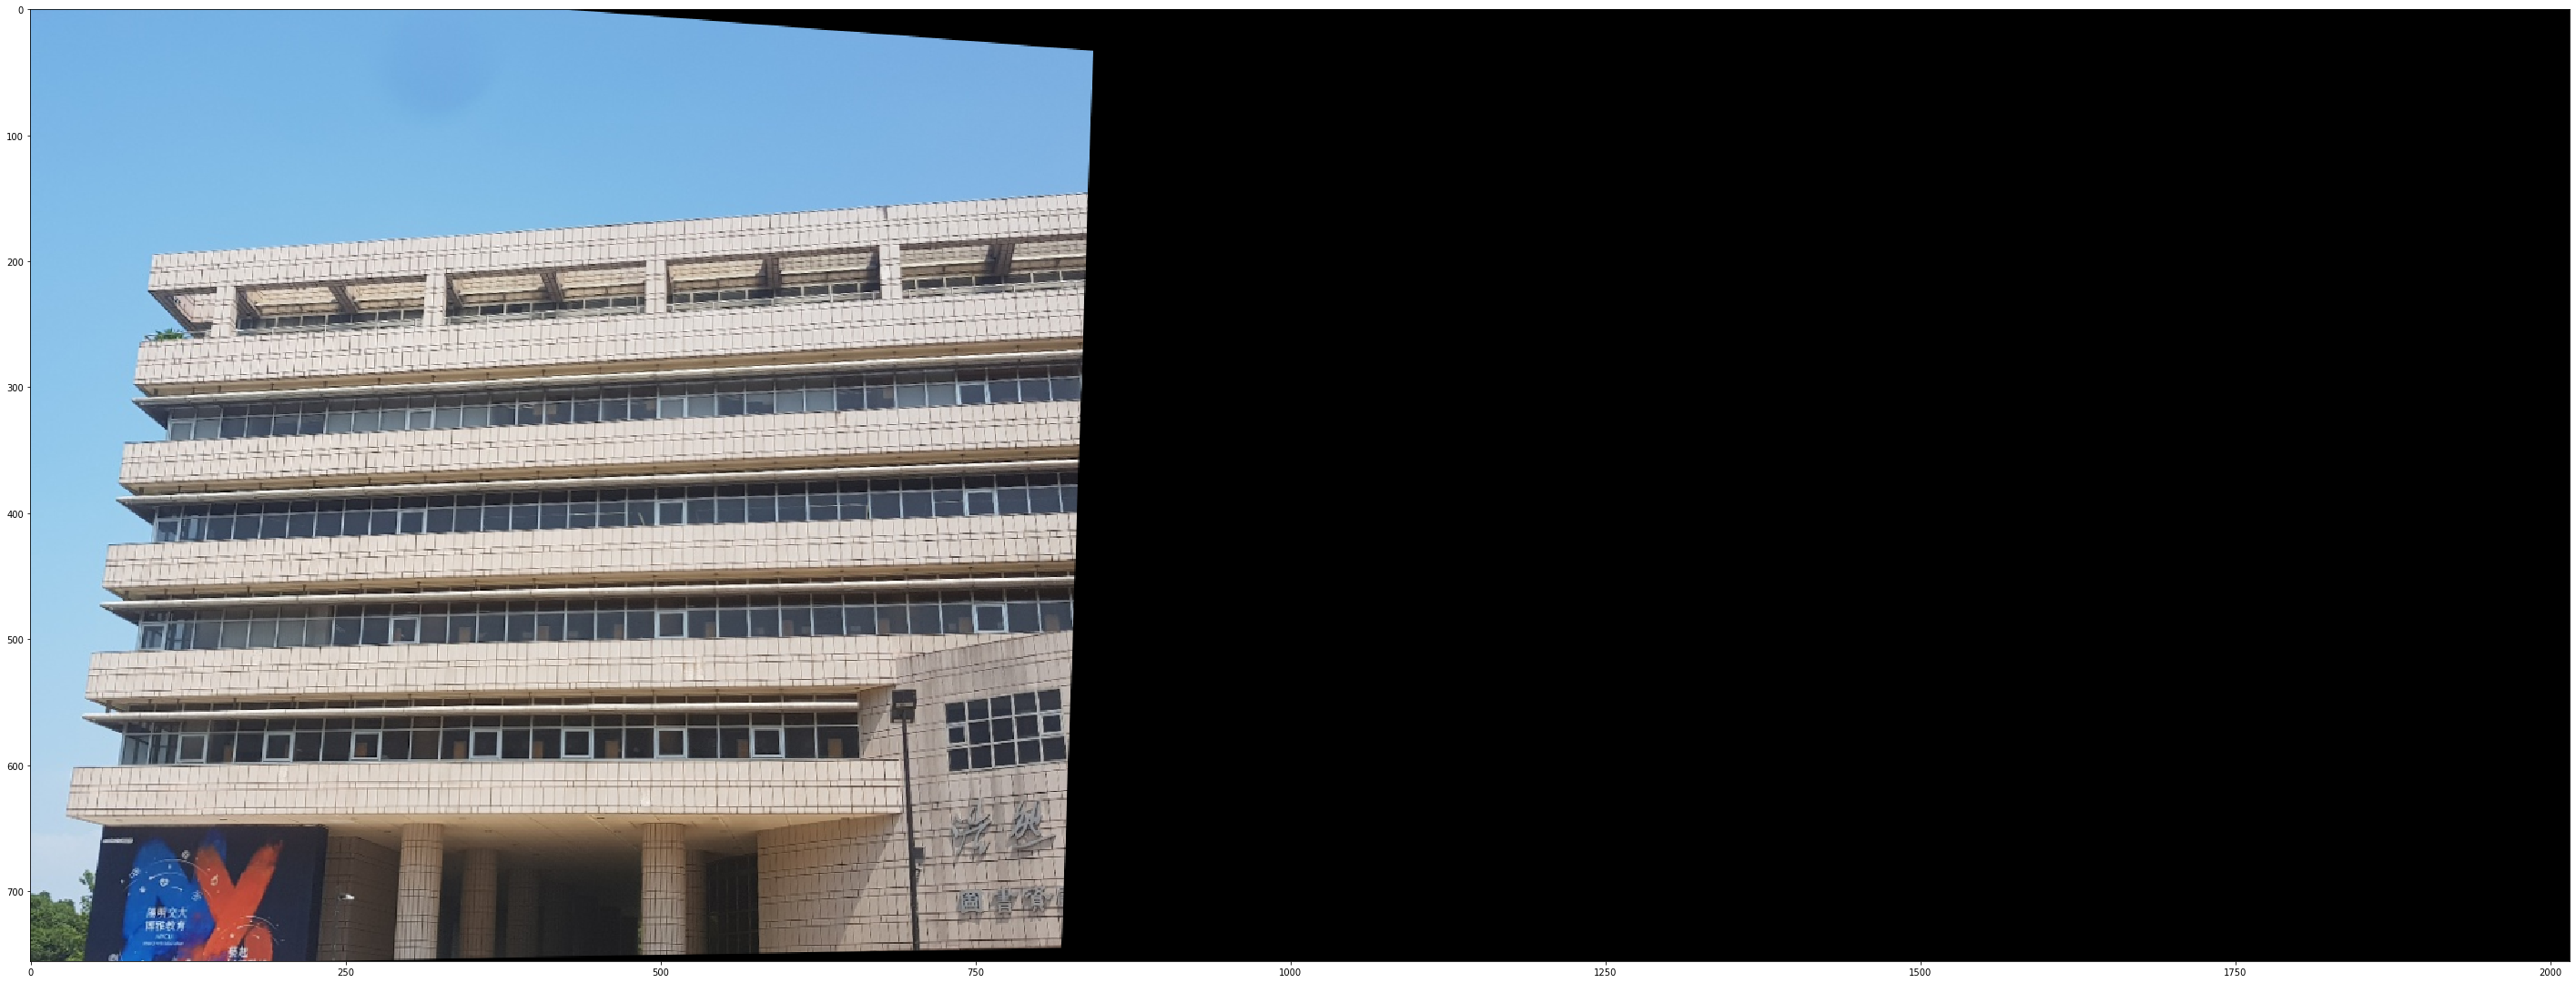

In [38]:
warp = cv2.warpPerspective(src=left_img, M=H, dsize=((left_img.shape[1] + right_img.shape[1]), right_img.shape[0]))
#warp[0:left_img.shape[0], 0:left_img.shape[1]] = left_img
plt.figure(figsize=(50,50))
plt.imshow(warp)